In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
#spark imports
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
import csv
from pyspark.sql.types import *
from pyspark.sql.functions import format_number, when
import pyspark.sql.functions as F

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#test CPU type
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
#change RAM allocation, current = 20GB
#change Core allocation, current = 3 Cores

spark = SparkSession.builder.appName("Project - Chicago crime")\
.config("spark.some.config.option", "some-value")\
.config("spark.driver.memory", "20g")\
.config("spark.driver.cores", '3')\
.getOrCreate()

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [0]:
crimes_schema = StructType([StructField("ID", IntegerType(), True),
                            StructField("Case Number", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("Primary Type", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("Location Description", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", IntegerType(), True),
                            StructField("District", IntegerType(), True),
                            StructField("Ward", IntegerType(), True),
                            StructField("Community Area", IntegerType(), True),
                            StructField("FBI Code", StringType(), True ),
                            StructField("X Coordinate", IntegerType(), True),
                            StructField("Y Coordinate", IntegerType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("Updated On", StringType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

In [0]:
data = spark.read.csv('/content/gdrive/My Drive/BigData/Crimes_-_2001_to_present.csv',header = True,schema = crimes_schema)

In [11]:
data.head(5)

[Row(ID=11034701, Case Number='JA366925', Date='01/01/2001 11:00:00 AM', Block='016XX E 86TH PL', IUCR='1153', Primary Type='DECEPTIVE PRACTICE', Description='FINANCIAL IDENTITY THEFT OVER $ 300', Location Description='RESIDENCE', Arrest=False, Domestic=False, Beat=412, District=4, Ward=8, Community Area=45, FBI Code='11', X Coordinate=None, Y Coordinate=None, Year=2001, Updated On='08/05/2017 03:50:08 PM', Latitude=None, Longitude=None, Location=None),
 Row(ID=11227287, Case Number='JB147188', Date='10/08/2017 03:00:00 AM', Block='092XX S RACINE AVE', IUCR='0281', Primary Type='CRIM SEXUAL ASSAULT', Description='NON-AGGRAVATED', Location Description='RESIDENCE', Arrest=False, Domestic=False, Beat=2222, District=22, Ward=21, Community Area=73, FBI Code='02', X Coordinate=None, Y Coordinate=None, Year=2017, Updated On='02/11/2018 03:57:41 PM', Latitude=None, Longitude=None, Location=None),
 Row(ID=11227583, Case Number='JB147595', Date='03/28/2017 02:00:00 PM', Block='026XX W 79TH ST', 

# Data preprocessing - Spark

**Working on data starting 2010.**

In [0]:
dataset = data.filter((data['Year'] >2009) & (data['Year'] !=2020))

In [0]:
#dropping columns which non-relative 

dataset = dataset.drop('ID')
dataset = dataset.drop('Case Number')
dataset = dataset.drop('FBI Code')
dataset = dataset.drop('Updated On')
dataset = dataset.drop('IUCR')# Could be useful - four digit codes that law enforcement agencies use to classify criminal incidents when taking individual reports.
dataset = dataset.drop('X Coordinate')
dataset = dataset.drop('Y Coordinate')
dataset = dataset.drop('Location')
dataset = dataset.drop('Description')
dataset = dataset.drop('Domestic')

**Preprocessing Primary types**

In [0]:
primaryCount = dataset.groupby('Primary Type').count()
primaryCount.orderBy('count', ascending=False).show()

+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|               THEFT|671393|
|             BATTERY|536171|
|     CRIMINAL DAMAGE|315708|
|           NARCOTICS|257342|
|             ASSAULT|192818|
|       OTHER OFFENSE|180674|
|            BURGLARY|170185|
|  DECEPTIVE PRACTICE|160807|
| MOTOR VEHICLE THEFT|129109|
|             ROBBERY|114506|
|   CRIMINAL TRESPASS| 75197|
|   WEAPONS VIOLATION| 41132|
|PUBLIC PEACE VIOL...| 24095|
|OFFENSE INVOLVING...| 23558|
| CRIM SEXUAL ASSAULT| 14724|
|        PROSTITUTION| 14646|
|INTERFERENCE WITH...| 11936|
|         SEX OFFENSE| 10769|
|            HOMICIDE|  5315|
|               ARSON|  4420|
+--------------------+------+
only showing top 20 rows



In [0]:
print('Distinct primary types '+ str(primaryCount.distinct().count()))

**Drop crimes which are not so significant**

In [0]:
dataset = dataset.filter((dataset['Primary Type']!='STALKING')&
                             (dataset['Primary Type']!='OBSCENITY')&
                             (dataset['Primary Type']!='NON-CRIMINAL (SUBJECT SPECIFIED)')&
                             (dataset['Primary Type']!='GAMBLING')&
                             (dataset['Primary Type']!='NON - CRIMINAL')&
                             (dataset['Primary Type']!='LIQUOR LAW VIOLATION')&
                             (dataset['Primary Type']!='PUBLIC INDECENCY')&
                             (dataset['Primary Type']!='HUMAN TRAFFICKING')&
                             (dataset['Primary Type']!='INTIMIDATION')&
                             (dataset['Primary Type']!='CONCEALED CARRY LICENSE VIOLATION')&
                             (dataset['Primary Type']!='NON-CRIMINAL')&
                             (dataset['Primary Type']!='OTHER NARCOTIC VIOLATION'))

**Merging similar crime types**

In [0]:
dataset = dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'CRIM SEXUAL ASSAULT') | \
                                    (dataset["Primary Type"] == 'PROSTITUTION') ,'SEX OFFENSE').otherwise(dataset['Primary Type']))
dataset=dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'WEAPONS VIOLATION') | \
                                    (dataset["Primary Type"] == 'INTERFERENCE WITH PUBLIC OFFICER') ,'PUBLIC PEACE VIOLATION').otherwise(dataset['Primary Type']))
dataset=dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'ARSON') ,'CRIMINAL TRESPASS').otherwise(dataset['Primary Type']))


In [0]:
primaryCount = dataset.groupby('Primary Type').count()
primaryCount.orderBy('count', ascending=False).show()

+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|               THEFT|671393|
|             BATTERY|536171|
|     CRIMINAL DAMAGE|315708|
|           NARCOTICS|257342|
|             ASSAULT|192818|
|       OTHER OFFENSE|180674|
|            BURGLARY|170185|
|  DECEPTIVE PRACTICE|160807|
| MOTOR VEHICLE THEFT|129109|
|             ROBBERY|114506|
|   CRIMINAL TRESPASS| 79617|
|PUBLIC PEACE VIOL...| 77163|
|         SEX OFFENSE| 40139|
|OFFENSE INVOLVING...| 23558|
|            HOMICIDE|  5315|
|          KIDNAPPING|  2202|
|CRIMINAL SEXUAL A...|   134|
+--------------------+------+



In [0]:
print('Distinct primary types after preprocessing '+ str(primaryCount.distinct().count()))

Distinct primary types after preprocessing 17


**Extract Day, Month, Week from Date Column**

In [0]:
dataset = dataset.withColumn("Day", F.split(dataset.Date, " ")[0])
dataset = dataset.withColumn("Day", F.to_date(dataset.Day, "MM/dd/yyyy"))
dataset = dataset.withColumn("Month", F.month(dataset.Day))
dataset = dataset.withColumn("WeekDay", F.dayofweek(dataset.Day))
dataset = dataset.withColumn("Year", F.year(dataset.Day))
dataset = dataset.na.drop()
dataset = dataset.drop('Date')
dataset = dataset.drop('Day')
dataset.head(5)

[Row(Block='102XX S VERNON AVE', Primary Type='SEX OFFENSE', Location Description='SCHOOL, PUBLIC, BUILDING', Arrest=False, Beat=511, District=5, Ward=9, Community Area=49, Year=2019, Latitude=41.708589, Longitude=-87.612583094, Month=4, WeekDay=4),
 Row(Block='032XX N KEELER AVE', Primary Type='OFFENSE INVOLVING CHILDREN', Location Description='RESIDENCE', Arrest=False, Beat=1731, District=17, Ward=30, Community Area=16, Year=2019, Latitude=41.940297617, Longitude=-87.732066473, Month=4, WeekDay=6),
 Row(Block='002XX N LARAMIE AVE', Primary Type='OFFENSE INVOLVING CHILDREN', Location Description='RESIDENCE', Arrest=False, Beat=1532, District=15, Ward=28, Community Area=25, Year=2019, Latitude=41.884865037, Longitude=-87.755230327, Month=4, WeekDay=6),
 Row(Block='108XX S DR MARTIN LUTHER KING JR DR', Primary Type='BATTERY', Location Description='RESIDENCE', Arrest=False, Beat=513, District=5, Ward=9, Community Area=49, Year=2019, Latitude=41.697609261, Longitude=-87.613507612, Month=4

Ignore Latitude and Longitude outside Chichago

In [0]:
dataset=dataset\
        .filter((dataset["Latitude"] < 45)
             & (dataset["Latitude"] > 40)
             & (dataset["Longitude"] < -85)
             & (dataset["Longitude"] > -90))

**Dropping Null values in the data.**

In [0]:
dataset=dataset.na.drop()

Data conversion to Pandas DataFrame for KNN

In [0]:
data = dataset.toPandas()

In [0]:
# canalso get preprocessed data
#data = pd.read_csv('/content/gdrive/My Drive/BigData/preprocessed.csv')

In [4]:
data.columns

Index(['Block', 'Primary Type', 'Location Description', 'Arrest', 'Beat',
       'District', 'Ward', 'Community Area', 'Year', 'Latitude', 'Longitude',
       'Month', 'WeekDay'],
      dtype='object')

# Data Visualization

In [0]:
primaryVisualizeDF = data.groupby('Primary Type').size()

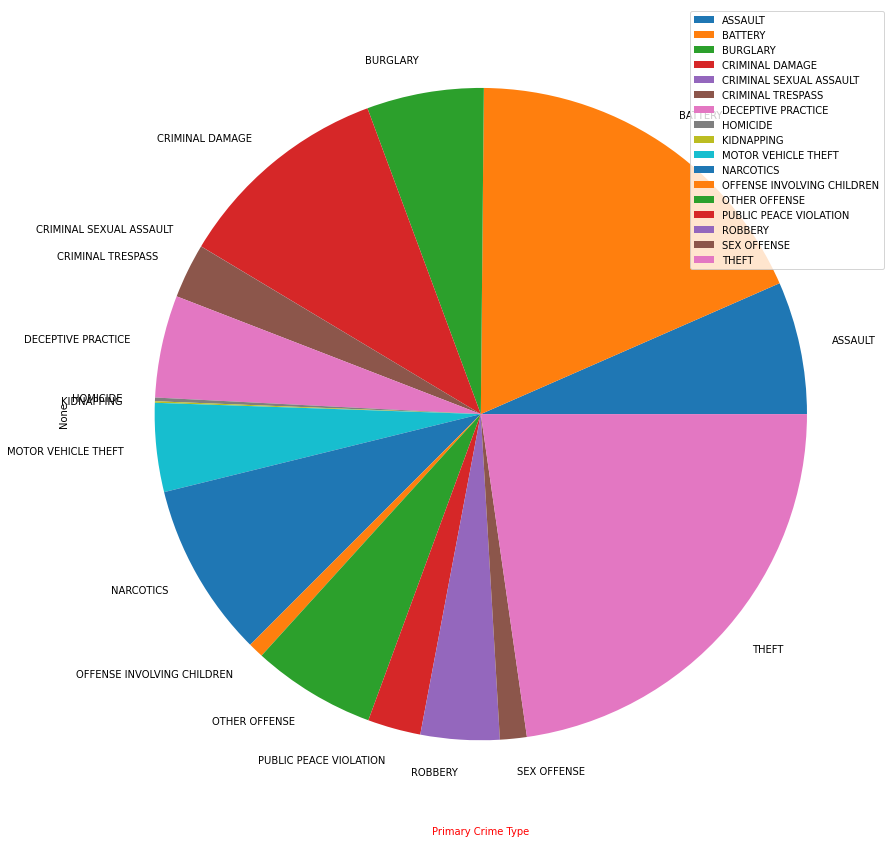

In [0]:
primaryVisualizeDF.plot.pie(figsize = (15,15))
plt.xlabel('Primary Crime Type', fontsize=10, color = 'red')
plt.legend()

# Preprocessing - specific to KNN model

In [0]:
data = data.replace(to_replace='None', value=np.nan).dropna()

**Label Encoding categorical variables**

In [0]:
# create an instance of label encoder for categorical variables
labelEncoder = LabelEncoder()

In [7]:
primaryEncoded = labelEncoder.fit_transform(data['Primary Type'])
primaryEncoded

array([15, 11, 11, ..., 12,  7,  7])

In [0]:
data['Primary Type'] = primaryEncoded

In [0]:
# create an instance of label encoder for categorical variables
labelEncoder2 = LabelEncoder()

In [10]:
locDiscEncoded = labelEncoder2.fit_transform(data['Location Description'])
locDiscEncoded

array([153, 133, 133, ...,  17,  37, 160])

In [0]:
data['Location Description'] = locDiscEncoded

In [0]:
# create an instance of label encoder for categorical variables
labelEncoder3 = LabelEncoder()

In [13]:
blockEncoded = labelEncoder2.fit_transform(data['Location Description'])
blockEncoded

array([153, 133, 133, ...,  17,  37, 160])

In [0]:
data['Block'] = locDiscEncoded

Use PCA to combine features

In [0]:
from sklearn.decomposition import PCA

In [0]:
location = data[['Latitude','Longitude']]
pca = PCA(n_components=1,random_state=123)

In [0]:
loc = pca.fit_transform(location)

In [0]:
data['Location'] = loc

In [19]:
data.head(5)

,Block,Primary Type,Location Description,Arrest,Beat,District,Ward,Community Area,Year,Latitude,Longitude,Month,WeekDay,Location
0,153,15,153,False,511,5,9,49,2019,41.708589,-87.612583,4,4,-0.145575
1,133,11,133,False,1731,17,30,16,2019,41.940298,-87.732066,4,6,0.115124
2,133,11,133,False,1532,15,28,25,2019,41.884865,-87.755230,4,6,0.076679
3,133,1,133,False,513,5,9,49,2019,41.697609,-87.613508,4,5,-0.154883
4,160,0,160,False,2222,22,21,73,2019,41.729973,-87.653167,5,2,-0.107851


# Feature selection

Checking importance of features using an ExtraTreesClassifier

In [0]:
#taking a fraction of data
data_sample = data.sample(frac=0.1, random_state=123)

In [0]:

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()

In [0]:

X = data_sample.loc[:, data.columns != 'Primary Type']

model.fit(X,data_sample['Primary Type'])

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [0]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

[0.06169809 0.06135702 0.04334372 0.06090417 0.01233077 0.03363271
 0.02964117 0.0924888  0.13077371 0.13091272 0.11603264 0.09655789
 0.13032659]


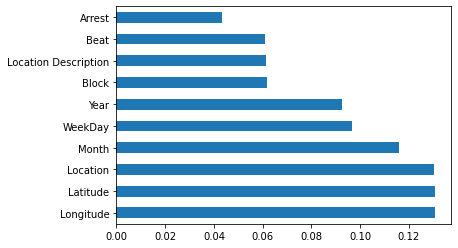

In [0]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
#plot for top 10 features
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Find corelation between data to find dependency between data columns

In [0]:
corelation = data.corr()
corelation

,Block,Primary Type,Location Description,Arrest,Beat,District,Ward,Community Area,Year,Latitude,Longitude,Month,WeekDay,Location
Block,1.000000,0.115127,1.000000,0.038168,0.014515,0.015081,-0.012151,0.012447,-0.029853,-0.038756,-0.015944,0.003408,0.002120,-0.026781
Primary Type,0.115127,1.000000,0.115127,0.039843,0.037460,0.035517,0.069905,-0.083323,-0.002116,0.087253,0.001026,0.007367,0.013911,0.070426
Location Description,1.000000,0.115127,1.000000,0.038168,0.014515,0.015081,-0.012151,0.012447,-0.029853,-0.038756,-0.015944,0.003408,0.002120,-0.026781
Arrest,0.038168,0.039843,0.038168,1.000000,-0.025085,-0.023351,-0.015733,0.020868,-0.064911,-0.026120,-0.034763,-0.030939,0.004530,-0.011070
Beat,0.014515,0.037460,0.014515,-0.025085,1.000000,0.980212,0.658243,-0.495143,-0.032528,0.634641,-0.532460,0.000218,0.002940,0.669146
District,0.015081,0.035517,0.015081,-0.023351,0.980212,1.000000,0.676552,-0.493580,-0.010671,0.638714,-0.552366,0.001527,0.002900,0.678232
Ward,-0.012151,0.069905,-0.012151,-0.015733,0.658243,0.676552,1.000000,-0.537736,0.016116,0.659018,-0.448022,0.005010,0.007056,0.664368
Community Area,0.012447,-0.083323,0.012447,0.020868,-0.495143,-0.493580,-0.537736,1.000000,-0.023129,-0.776675,0.246489,-0.007679,-0.008425,-0.701172
Year,-0.029853,-0.002116,-0.029853,-0.064911,-0.032528,-0.010671,0.016116,-0.023129,1.000000,0.014542,0.012898,0.006959,-0.002125,0.008039
Latitude,-0.038756,0.087253,-0.038756,-0.026120,0.634641,0.638714,0.659018,-0.776675,0.014542,1.000000,-0.548820,0.005587,0.006862,0.970047


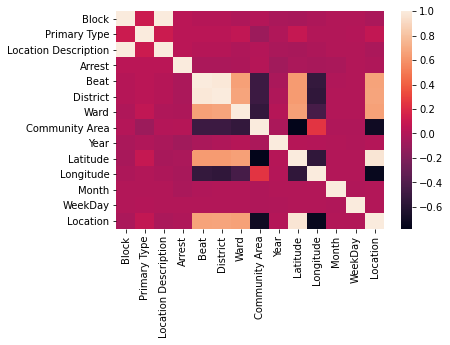

In [0]:
sns.heatmap(corelation)

**Based on the above outputs, we have decided that below selected columns are corelated and best params for our KNN model**

In [0]:
selected_columns = ['Latitude','Longitude','Location Description','Block','WeekDay']
#selected_columns = ['Latitude','Longitude']

# Splitting data in train and test

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[selected_columns], data['Primary Type'], test_size=0.3) # 70% training and 30% test

# Building initial KNN Classifier

**Initially we will build our classifier with 5 neighbours**

In [0]:
knn_5 = KNeighborsClassifier(n_neighbors=5) 
knn_5.fit(X_train,y_train)
pred_train = knn_5.predict(X_train)
pred_i = knn_5.predict(X_test)
print('Test accuracy ', metrics.accuracy_score(y_train, pred_train))
print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Test accuracy  0.4785072963503379
Accuracy  0.2894782043888117
F1 score  0.28138838412651623


We will deploy Elbow method to get optimum number of neighbours

In [0]:
error_rate = []

krange = range(10,50,5)
for i in krange:
 
 knn = KNeighborsClassifier(n_neighbors=i, metric='manhattan', weights = 'uniform',n_jobs= -1) # haversine - if only lat long
 knn.fit(X_train,y_train)
 pred_train = knn.predict(X_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))
 print('Neighbours ',i)
 print('Test accuracy ', metrics.accuracy_score(y_train, pred_train))
 print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
 print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Neighbours  10
Test accuracy  0.42483123548737317
Accuracy  0.3126940196724146
F1 score  0.29331483794081864
Neighbours  15
Test accuracy  0.40340458973172694
Accuracy  0.3230170890878047
F1 score  0.29645248056689477
Neighbours  20
Test accuracy  0.3914327542826722
Accuracy  0.3290732898115002
F1 score  0.297561296424232
Neighbours  25
Test accuracy  0.38360282191523043
Accuracy  0.3323743969678045
F1 score  0.2969661610892852
Neighbours  30
Test accuracy  0.37859655982188256
Accuracy  0.3349372482507658
F1 score  0.29666538069152276
Neighbours  35
Test accuracy  0.3746784248092974
Accuracy  0.33626815637374174
F1 score  0.29599169369921274
Neighbours  40
Test accuracy  0.3714603572196403
Accuracy  0.33748417413738385
F1 score  0.2952621272392315
Neighbours  45
Test accuracy  0.36888678066975394
Accuracy  0.3387456930334354
F1 score  0.2949948644357232


Text(0, 0.5, 'Error Rate')

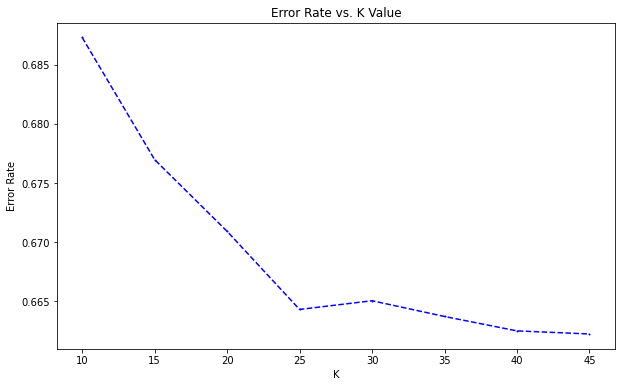

In [0]:
plt.figure(figsize=(10,6))

plt.plot(krange,error_rate, color= 'blue', linestyle= 'dashed', marker= 'o', markerfacecolor='red', markersize=1)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

K = 25, optimum

# Grid Search/ Random Search -KNN

**To find optimal paramteres for KNN Model, we will implement Grid search.**

In [0]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [0]:
KNeighborsClassifier().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [0]:
grid_params = {
    'weights' : ['uniform', 'distance'],
    'metric' : ['manhattan','jaccard'] #haversine - if only lat long
}

In [0]:
randomSearch = RandomizedSearchCV(
    KNeighborsClassifier(25),
    grid_params,
    verbose = 1,
    cv =3,
    random_state = 123
    )


In [0]:
#takes very long time
rs_results = randomSearch.fit(X_train_gs, y_train_gs)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  6.5min finished


In [0]:
rs_results.best_score_

0.3096858524213952

In [0]:
rs_results.best_params_

{'metric': 'manhattan', 'weights': 'uniform'}

# Oversmapling -SMOTE to balance dataset

In [0]:
from imblearn.over_sampling import SMOTE

In [0]:
# Oversample 'Majority'
sm = SMOTE('minority', random_state=123)

In [0]:
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [0]:
#convert back to Dataframe
X_train_updated = pd.DataFrame(X_train_res, columns= selected_columns)
y_train_updated = pd.Series(y_train_res)

In [0]:
target_counts = y_train_updated.value_counts()
target_counts

16    466887
4     466887
1     374663
3     220576
10    177724
0     134718
12    125694
2     119325
6     103810
9      90189
14     79815
5      55519
13     54141
15     27124
11     15700
7       3706
8       1553
dtype: int64

In [0]:
knn = KNeighborsClassifier(n_neighbors=25, metric='manhattan', weights = 'uniform')

In [0]:
knn.fit(X_train_updated,y_train_updated)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

In [0]:
pred_i = knn.predict(X_test)

In [0]:
print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Accuracy  0.3295920027209677
F1 score  0.2962310053713088


Oversampling the Minority classed helped with an increase in accuracy and F1 score

# Undersampling - Cluster Centroids

In [0]:
from imblearn.under_sampling import ClusterCentroids

In [0]:
# Undersample 'Majority'
cc = ClusterCentroids(sampling_strategy = 'majority')

In [0]:
X_cc, y_cc = cc.fit_sample(X_train, y_train)

In [0]:
#convert back to Dataframe
X_train_updated = pd.DataFrame(X_cc, columns= selected_columns)
y_train_updated = pd.Series(y_cc)

In [0]:
target_counts = y_train_updated.value_counts()
target_counts

1     374663
3     220576
10    177724
0     134718
12    125694
2     119325
6     103810
9      90189
14     79815
5      55519
13     54141
15     27124
11     15700
7       3706
8       1553
4         87
16        87
dtype: int64

In [0]:
knn = KNeighborsClassifier(n_neighbors=25, metric='manhattan', weights = 'uniform')

In [0]:
knn.fit(X_train_updated,y_train_updated)

In [0]:
pred_i = knn.predict(X_test)

In [0]:
print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Accuracy  0.24927226626352664
F1 score  0.1955424370821218


Undersampling using cluster centroids does not help much in high dimensional data

# Random Sampling

In [0]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [0]:
# define oversampling strategy
over = RandomOverSampler(sampling_strategy= 'minority') 

In [0]:
# fit and apply the transform
X_random, y_random = over.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
#convert back to Dataframe
X_train_updated = pd.DataFrame(X_random, columns= selected_columns)
y_train_updated = pd.Series(y_random)

In [0]:
target_counts_random = y_train_updated.value_counts()
target_counts_random

16    466887
4     466887
1     374663
3     220576
10    177724
0     134718
12    125694
2     119325
6     103810
9      90189
14     79815
5      55519
13     54141
15     27124
11     15700
7       3706
8       1553
dtype: int64

In [0]:
knn = KNeighborsClassifier(n_neighbors=25, metric='manhattan', weights = 'uniform')

In [0]:
knn.fit(X_train_updated,y_train_updated)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

In [0]:
pred_i = knn.predict(X_test)

In [0]:
print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Accuracy  0.3328214455937272
F1 score  0.2973019662409677


OverSampling minority class improves model 

In [0]:
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy= 'majority')

In [0]:
# fit and apply the transform
X_train_updated, y_train_updated = under.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
y_train_updated = pd.Series(y_train_updated)
target_counts_random = y_train.value_counts()
target_counts_random

16    466887
1     374663
3     220576
10    177724
0     134718
12    125694
2     119325
6     103810
9      90189
14     79815
5      55519
13     54141
15     27124
11     15700
7       3706
8       1553
4         87
Name: Primary Type, dtype: int64

In [0]:
knn = KNeighborsClassifier(n_neighbors=25, metric='manhattan', weights = 'uniform')

In [0]:
knn.fit(X_train_updated,y_train_updated)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

In [0]:
pred_i = knn.predict(X_test)

In [0]:
print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Accuracy  0.24930184199959277
F1 score  0.19552605947705762


Oversampling does not have significant impact on model

# Ensemble models

Here we will try ensemble of Various classification models 

In [0]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [0]:
#KNN with - 25 neighbours
knn = KNeighborsClassifier(25, metric='manhattan', weights = 'uniform',n_jobs= -1)

#random forest with 75 Decision Trees
rf = RandomForestClassifier(10, max_depth = 10, n_jobs= -1)

#Support Vector Classifier
svm = SVC(kernel = 'linear', random_state = 123, probability=True)

In [45]:
# can using previopusly trained KNN as well
knn.fit(X_train1,y_train1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=25, p=2,
                     weights='uniform')

In [39]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [40]:
rf.score(X_test, y_test)

0.3365866643006078

In [35]:
svm.fit(X_train1,y_train1)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=123, shrinking=True, tol=0.001,
    verbose=False)

In [36]:
svm.score(X_test, y_test)

0.22814267790089626

In [0]:
#create a dictionary of our models
estimators=[('knn', knn), ('rf', rf), ('svm', svm)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

In [0]:
#fit model to training data
ensemble.fit(X_train, y_train)
#test our model on the test data
ensemble.score(X_test, y_test)